##### Installing latest version of albumentation because old code doesn't has Coarseout

In [1]:
!pip install albumentations==0.4.5

In [0]:
%matplotlib inline

### Importing Libraries

In [3]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls

drive  sample_data


In [0]:
# Changing working directory
import os
os.chdir('drive/My Drive/EVA4/assignment10')

In [6]:
!ls

10_final.ipynb	  gradcam.py	map.jpg		      test_.py
data		  img1.png	model.py	      torch_lr_finder
dataset9.py	  __init__.py	__pycache__	      trainalbumentation.py
general_utils.py  lr_finder.py	testalbumentation.py  train_.py


In [7]:
# checking present working directory
!pwd

/content/drive/My Drive/EVA4/assignment10


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from gradcam import *

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from dataset import Data
from model import ResNet18

### Downloading train and test dataset using (dataset) module

In [9]:
data = Data()
trainset = data.getTrainDataSet(train=True)
testset = data.getTestDataSet(train=False)

Files already downloaded and verified
Files already downloaded and verified


### Creating Test/Train Dataloaders, another train and test loaders to visualise image and gradcam loader which will be used in visualising images using GradCAM

In [0]:
train_loader = data.getDataLoader(dataset=trainset,batches=128)
test_loader = data.getDataLoader(testset,128)
img_train_loader = data.getDataLoader(trainset,4)
img_test_loader = data.getDataLoader(testset,4)
test_grad_loader = data.getDataLoader(testset,1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Visualizing images



  pip install torch-lr-finder -v --global-option="amp"


plane   dog  deer  deer


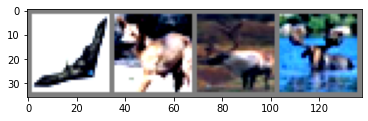

In [11]:
from general_utils import imshow

# get some random training images
dataiter = iter(img_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Model Parameters

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

netobj = ResNet18()
model = netobj.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

### Finding Best Learning rate through (lr_finder) module

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



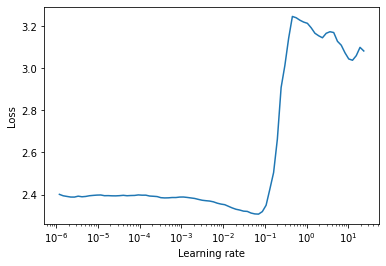

In [13]:
from general_utils import lr_finder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder(model, optimizer, criterion, train_loader)
#lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")

### Training and Testing Loss

In [14]:
from train_ import train
from test_ import test
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


model =  netobj.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
EPOCHS = 50


test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
loss=1000
loss = 1000
for epoch in range(50):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    print("EPOCH :", epoch)
    trainacc, loss = train(model, device, train_loader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(model, device, test_loader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    scheduler.step(loss1)
print('Finished Training')

  0%|          | 0/391 [00:00<?, ?it/s]

lr=  0.1
EPOCH : 0


Epoch= 0 Loss=1.4264709949493408 Batch_id=390 Accuracy=53.75: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.5774063 Test Accuracy= 43.58
lr=  0.1
EPOCH : 1


Epoch= 1 Loss=1.0528624057769775 Batch_id=390 Accuracy=60.00: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.0876403 Test Accuracy= 58.31
lr=  0.1
EPOCH : 2


Epoch= 2 Loss=1.138086199760437 Batch_id=390 Accuracy=63.75: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.0374198 Test Accuracy= 66.54
lr=  0.1
EPOCH : 3


Epoch= 3 Loss=0.7424899935722351 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.5522871 Test Accuracy= 71.72
lr=  0.1
EPOCH : 4


Epoch= 4 Loss=0.753738522529602 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.7038654 Test Accuracy= 76.25
lr=  0.1
EPOCH : 5


Epoch= 5 Loss=0.48429131507873535 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.3625278 Test Accuracy= 79.2
lr=  0.1
EPOCH : 6


Epoch= 6 Loss=0.5812996029853821 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:38<00:00, 10.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.8644341 Test Accuracy= 80.78
lr=  0.1
EPOCH : 7


Epoch= 7 Loss=0.6354566812515259 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.786577 Test Accuracy= 81.36
lr=  0.1
EPOCH : 8


Epoch= 8 Loss=0.3603810667991638 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.5142551 Test Accuracy= 83.74
lr=  0.1
EPOCH : 9


Epoch= 9 Loss=0.4922218322753906 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.61703986 Test Accuracy= 82.9
lr=  0.05
EPOCH : 10


Epoch= 10 Loss=0.16548825800418854 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.24635674 Test Accuracy= 86.32
lr=  0.05
EPOCH : 11


Epoch= 11 Loss=0.19377431273460388 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.6791507 Test Accuracy= 86.31
lr=  0.05
EPOCH : 12


Epoch= 12 Loss=0.24602946639060974 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.17308977 Test Accuracy= 85.21
lr=  0.05
EPOCH : 13


Epoch= 13 Loss=0.1393483579158783 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.0758138 Test Accuracy= 86.53
lr=  0.05
EPOCH : 14


Epoch= 14 Loss=0.23494064807891846 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.21138385 Test Accuracy= 86.02
lr=  0.05
EPOCH : 15


Epoch= 15 Loss=0.22283633053302765 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.16017818 Test Accuracy= 85.28
lr=  0.05
EPOCH : 16


Epoch= 16 Loss=0.15499861538410187 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.651981 Test Accuracy= 85.23
lr=  0.05
EPOCH : 17


Epoch= 17 Loss=0.05582995340228081 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.15569893 Test Accuracy= 85.97
lr=  0.05
EPOCH : 18


Epoch= 18 Loss=0.12893252074718475 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.6002223 Test Accuracy= 86.02
lr=  0.05
EPOCH : 19


Epoch= 19 Loss=0.03433629125356674 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.30870312 Test Accuracy= 86.91
lr=  0.05
EPOCH : 20


Epoch= 20 Loss=0.10063917934894562 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.18502977 Test Accuracy= 86.76
lr=  0.05
EPOCH : 21


Epoch= 21 Loss=0.058951862156391144 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.6866295 Test Accuracy= 85.95
lr=  0.025
EPOCH : 22


Epoch= 22 Loss=0.05623110011219978 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.5882575 Test Accuracy= 88.18
lr=  0.025
EPOCH : 23


Epoch= 23 Loss=0.010054278187453747 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.1340843 Test Accuracy= 88.33
lr=  0.025
EPOCH : 24


Epoch= 24 Loss=0.02390102669596672 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.1749216 Test Accuracy= 88.22
lr=  0.025
EPOCH : 25


Epoch= 25 Loss=0.025589603930711746 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.22688136 Test Accuracy= 88.3
lr=  0.0125
EPOCH : 26


Epoch= 26 Loss=0.0031192898750305176 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.21568039 Test Accuracy= 88.84
lr=  0.0125
EPOCH : 27


Epoch= 27 Loss=0.0018336891662329435 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.192367 Test Accuracy= 88.99
lr=  0.0125
EPOCH : 28


Epoch= 28 Loss=0.0069408295676112175 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.009840727 Test Accuracy= 88.99
lr=  0.0125
EPOCH : 29


Epoch= 29 Loss=0.014517098665237427 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.61438733 Test Accuracy= 89.07
lr=  0.0125
EPOCH : 30


Epoch= 30 Loss=0.04137825965881348 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.5583463 Test Accuracy= 89.01
lr=  0.0125
EPOCH : 31


Epoch= 31 Loss=0.0019211411708965898 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.11353257 Test Accuracy= 88.81
lr=  0.0125
EPOCH : 32


Epoch= 32 Loss=0.0015236735343933105 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.16779912 Test Accuracy= 88.9
lr=  0.00625
EPOCH : 33


Epoch= 33 Loss=0.0032729923259466887 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:38<00:00, 10.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.3890114 Test Accuracy= 89.0
lr=  0.00625
EPOCH : 34


Epoch= 34 Loss=0.002587008522823453 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.09648889 Test Accuracy= 89.07
lr=  0.00625
EPOCH : 35


Epoch= 35 Loss=0.0013035893207415938 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.678726 Test Accuracy= 89.16
lr=  0.00625
EPOCH : 36


Epoch= 36 Loss=0.002081936690956354 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.17095876 Test Accuracy= 89.17
lr=  0.003125
EPOCH : 37


Epoch= 37 Loss=0.0038290799129754305 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.09537488 Test Accuracy= 89.2
lr=  0.003125
EPOCH : 38


Epoch= 38 Loss=0.0007678151014260948 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.5315529 Test Accuracy= 89.13
lr=  0.003125
EPOCH : 39


Epoch= 39 Loss=0.00532571692019701 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.2153798 Test Accuracy= 89.24
lr=  0.003125
EPOCH : 40


Epoch= 40 Loss=0.005643778946250677 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.47306406 Test Accuracy= 89.14
lr=  0.0015625
EPOCH : 41


Epoch= 41 Loss=0.001472044037654996 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.2904172 Test Accuracy= 89.14
lr=  0.0015625
EPOCH : 42


Epoch= 42 Loss=0.05284352973103523 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.11764896 Test Accuracy= 89.23
lr=  0.0015625
EPOCH : 43


Epoch= 43 Loss=0.0009248256683349609 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.0648241 Test Accuracy= 89.2
lr=  0.0015625
EPOCH : 44


Epoch= 44 Loss=0.001385462237522006 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.5989394 Test Accuracy= 89.37
lr=  0.00078125
EPOCH : 45


Epoch= 45 Loss=0.0013061284553259611 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:38<00:00, 10.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.0027000308 Test Accuracy= 89.25
lr=  0.00078125
EPOCH : 46


Epoch= 46 Loss=0.0002259731263620779 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.28483367 Test Accuracy= 89.27
lr=  0.00078125
EPOCH : 47


Epoch= 47 Loss=0.000986850238405168 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.23042843 Test Accuracy= 89.27
lr=  0.00078125
EPOCH : 48


Epoch= 48 Loss=0.0004206061421427876 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.40459588 Test Accuracy= 89.38
lr=  0.00078125
EPOCH : 49


Epoch= 49 Loss=0.001270854496397078 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
100%|██████████| 79/79 [00:02<00:00, 30.94it/s]


Test Loss= 0.6632105 Test Accuracy= 89.24
Finished Training


### Plotting Train and Test Accuracy curves

Text(0, 0.5, 'Accuracy')

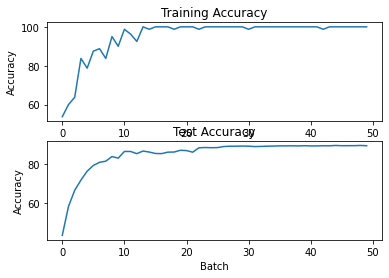

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")

In [0]:
# outputs = model(images.cuda())

### Checking Ground Truth and Predicted Class

GT     bird        car        cat       frog
Pred   bird        car        cat       frog


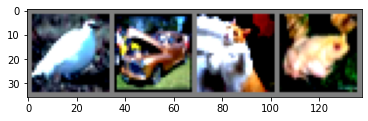

In [16]:
from general_utils import imshow
dataiter = iter(img_test_loader)
images, labels = dataiter.next()

# print images (Ground Truth)
imshow(torchvision.utils.make_grid(images))
print('GT   ', '      '.join('%5s' % classes[labels[j]] for j in range(4)))

# print predicted images
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Pred ', '      '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
# def OverallAcc(testloader, model):
#   # dataiter = iter(testloader)
#   # images, labels = dataiter.next()
#   correct = 0
#   total = 0

#   with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = model(images.cuda())
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels.cuda()).sum().item()

#   print('Accuracy of the network on the 10000 test images: %d %%' % (
#       100 * correct / total))
#   class_correct = list(0. for i in range(10))
#   class_total = list(0. for i in range(10))
#   with torch.no_grad():
#       for data in test_loader:
#           images, labels = data
#           images = images.cuda()
#           labels = labels.cuda()
#           outputs = model(images)
#           _, predicted = torch.max(outputs, 1)
#           c = (predicted == labels).squeeze()
#           for i in range(4):
#               label = labels[i]
#               class_correct[label] += c[i].item()
#               class_total[label] += 1


#   for i in range(10):
#       print('Accuracy of %5s : %2d %%' % (
#           classes[i], 100 * class_correct[i] / class_total[i]))

In [29]:
from general_utils import OverallAcc
OverallAcc(testloader = test_loader, model = model)

Accuracy of the network on the 10000 test images: 89 %
Accuracy of plane : 94 %
Accuracy of   car : 100 %
Accuracy of  bird : 88 %
Accuracy of   cat : 86 %
Accuracy of  deer : 86 %
Accuracy of   dog : 80 %
Accuracy of  frog : 86 %
Accuracy of horse : 88 %
Accuracy of  ship : 85 %
Accuracy of truck : 96 %


### Analyzing 25 missclassified images through GradCam


In [0]:
import gradcam
it = iter(test_grad_loader)

/content/drive/My Drive/EVA4/assignment10/gradcam.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=3)


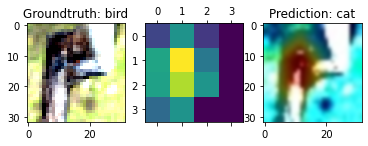

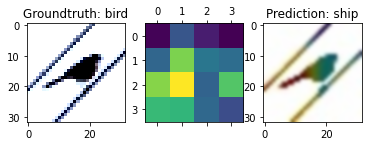

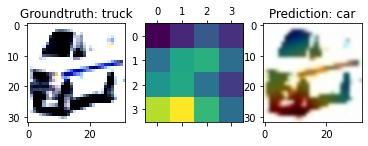

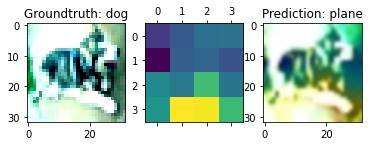

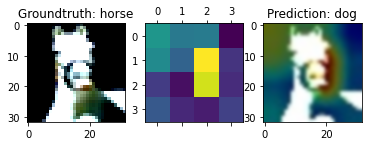

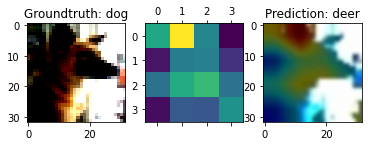

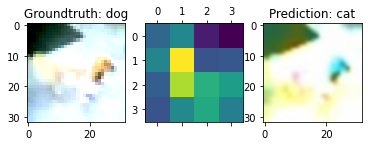

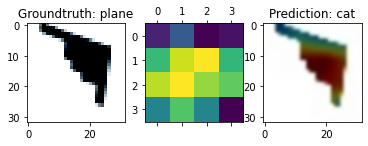

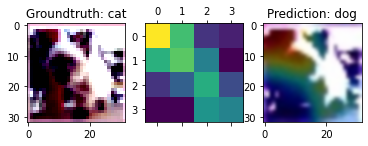

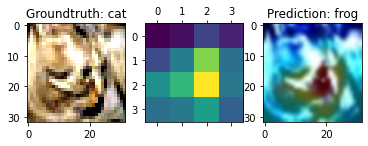

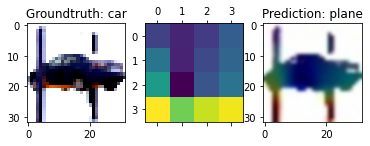

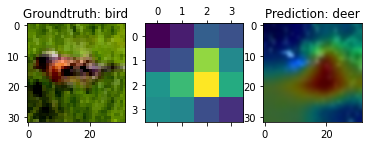

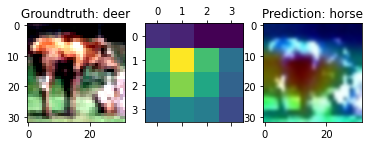

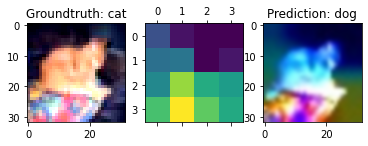

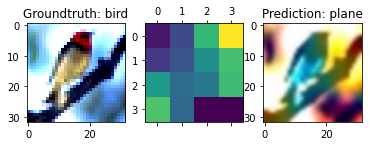

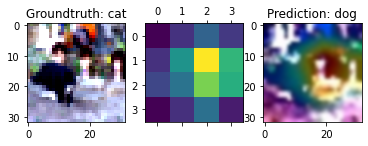

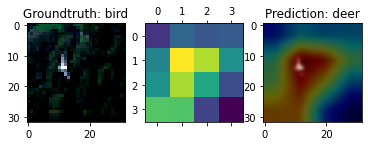

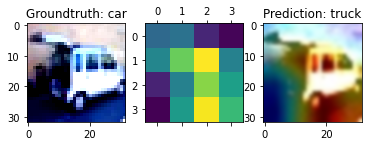

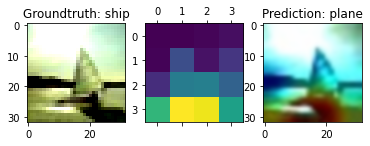

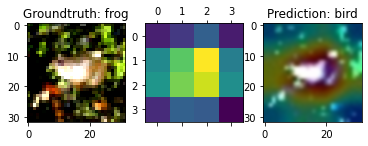

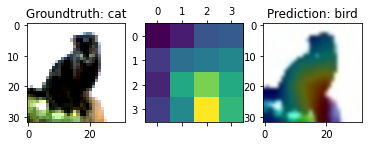

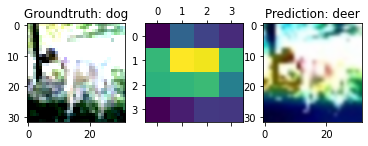

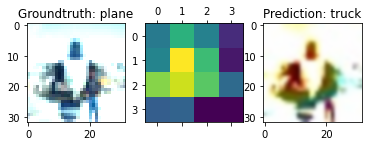

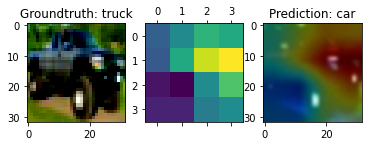

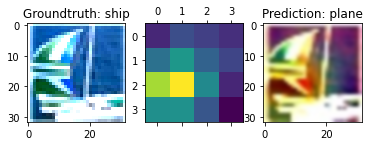

In [36]:
count = 0
while(count != 25):
    images, labels = it.next()
    output = model(images.cuda())
    pred = output.argmax(dim=1, keepdim=True)
    if(classes[pred] != classes[labels]):
      gradcam.gradcamof(model, images, classes, str(classes[labels]), str(classes[pred]))
      count=count+1